In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="6"
# import tensorflow as tf
# gpu_options = tf.GPUOptions(allow_growth=True)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

import numpy as np
import cv2
from tqdm import tqdm
import glob
import os.path as osp
import random
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
from tf_utils import weight_variable, bias_variable, dense_to_one_hot
import matplotlib.pyplot as plt

/data2/wangpengxiao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# spray_texture = "/data4/wangpengxiao/color_spray_texture"
# spray_texture_path = glob.glob(osp.join(spray_texture,'*.jpg'))  
# spray_texture_path = sorted(spray_texture_path)

In [3]:
# img = cv2.imread(spray_texture_path[0])

In [4]:
# for i in range(np.size(img,0)):
#     for j in range(np.size(img,1)):
#         img[i,j,:] = 255 - img[i,j,:]

# im = Image.fromarray(img.astype('uint8'))        

In [5]:
# tem = im.copy()
# tem.paste(im,(0,35))

In [6]:
# plt.imshow(tem)

In [7]:
# plt.imshow(im)

In [8]:
# tem = np.array(tem)
# im = np.array(im)
# for i in range(np.size(tem,0)):
#     for j in range(np.size(tem,1)):
#         if (tem[i,j,:]==[0,0,0]).all() and (im[i,j,:]!=[0,0,0]).all():
#             tem[i,j,:] = im[i,j,:]

In [9]:
# plt.imshow(tem)

In [10]:
# for i in range(np.size(tem,0)):
#     for j in range(np.size(tem,1)):
#         if (im[i,j,:]!=[0,0,0]).all():
#             im[i,j,:] = im[i,j,:] - 10

In [11]:
# plt.imshow(im)

In [12]:
# lamda = 0.03
# paper = np.zeros(im.shape)
# center = [int(im.shape[0]/2),int(im.shape[1]/2)]
# color = np.array([255,255,0])
# paper[center[0],center[1],:] = color
# for i in range(np.size(im,0)):
#     for j in range(np.size(im,1)):
#         dis = np.sqrt(np.sum(np.square(np.array([i,j])-np.array(center))))+0.01
#         paper[i,j,:] = np.array(color)*lamda/dis

# paper = np.maximum(paper,0)
# paper = np.minimum(paper,1)
# paper = (paper*255.).astype('uint8')
# plt.imshow(paper)

In [13]:
# paper[20,35]

In [14]:
# paper.min()

In [20]:
#提取图片主要色
import colorsys
 
def get_dominant_color(image):
    
#颜色模式转换，以便输出rgb颜色值
    image = image.convert('RGBA')
    
#生成缩略图，减少计算量，减小cpu压力
    image.thumbnail((200, 200))
    
    max_score = 0#原来的代码此处为None
    dominant_color = 0#原来的代码此处为None，但运行出错，改为0以后 运行成功，原因在于在下面的 score > max_score的比较中，max_score的初始格式不定
    
    for count, (r, g, b, a) in image.getcolors(image.size[0] * image.size[1]):
        # 跳过纯黑色
        if a == 0:
            continue
        
        saturation = colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)[1]
       
        y = min(abs(r * 2104 + g * 4130 + b * 802 + 4096 + 131072) >> 13, 235)
       
        y = (y - 16.0) / (235 - 16)
        
        # 忽略高亮色
        if y > 0.9:
            continue
            
        # 忽略白背景
        if ((r>230)&(g>230)&(b>230)):
            continue
        
        # Calculate the score, preferring highly saturated colors.
        # Add 0.1 to the saturation so we don't completely ignore grayscale
        # colors by multiplying the count by zero, but still give them a low
        # weight.
        score = (saturation + 0.1) * count
        
        if score > max_score:
            max_score = score
            dominant_color = (b, g, r)
    
    return dominant_color

In [21]:
def min_dis(point, point_list):
    dis = []
    for p in point_list:
        dis.append(np.sqrt(np.sum(np.square(np.array(point)-np.array(p)))))
    
    return min(dis)

In [22]:
###############success#######################
source_data_path = "/data4/wangpengxiao/zalando"
source_img_path = glob.glob(osp.join(source_data_path,'*.jpg'))  
source_img_path = sorted(source_img_path)

save_color_spray = '/data4/wangpengxiao/zalando_color_spray'

# path = source_img_path[4]
for path in tqdm(source_img_path):
    img = cv2.imread(path)
    h = int(img.shape[0]/30)
    w = int(img.shape[1]/30)
    a_x = np.random.randint(0, h)
    a_y = np.random.randint(0, w)
    b_x = np.random.randint(0, h)
    b_y = np.random.randint(0, w)
    begin_point = np.array([min(a_x,b_x),a_y])
    end_point = np.array([max(a_x,b_x),b_y])
    tan = (begin_point[1] - end_point[1]) / (begin_point[0] - end_point[0]+0.001)


    center_point_list = []
    for i in range(begin_point[0],end_point[0]+1):
        a = i
        b = (i-begin_point[0])*tan + begin_point[1]
        center_point_list.append(np.array([int(a),int(b)]))
    center_point_list = np.array(center_point_list)    


    lamda = np.random.randint(5, 11)/100#一个超参
    paper = np.zeros((h,w,3))
    mask = np.zeros((h,w))
    center = [int(h/2),int(w/2)]
    color = get_dominant_color(Image.fromarray(img))#提取图片主要色
    #color = img[int(img.shape[0]/2),int(img.shape[1]/2),:]#提取图片主要色
    # color = img[int(img.shape[0]*3/5),int(img.shape[1]*1/2),:]
    # color = np.array([255,255,0])
    paper[center[0],center[1],:] = color
    for i in range(h):
        for j in range(w):
            dis = min_dis([i, j],center_point_list)
            paper[i,j,:] = np.array(color)/np.exp(lamda*dis)#*lamda/dis
            mask[i,j] = np.array([255])/np.exp(lamda*dis)#*lamda/dis

#     paper = np.maximum(paper,0)
#     paper = np.minimum(paper,255)
    paper = (paper).astype('uint8')

#     mask = np.maximum(mask,0)
#     mask = np.minimum(mask,255)
    mask = (mask).astype('uint8')

    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    im = cv2.resize(paper, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    imq = Image.fromarray(im)
    imp = Image.open(path).convert('RGB')

    imp.paste(imq,(0, 0, imp.size[0], imp.size[1]),mask = Image.fromarray(mask))

    imp.save(osp.join(save_color_spray, osp.basename(path)))    


  0%|          | 30/30173 [00:33<9:21:41,  1.12s/it]

KeyboardInterrupt: 

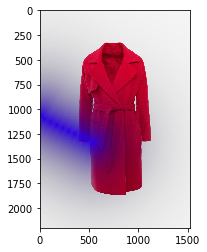

In [19]:
# plt.imshow(imp)

In [ ]:
# ###############success#######################
# source_data_path = "/data4/wangpengxiao/zalando"
# source_img_path = glob.glob(osp.join(source_data_path,'*.jpg'))  
# source_img_path = sorted(source_img_path)

# save_color_spray = '/data4/wangpengxiao/zalando_color_spray'

# path = source_img_path[4]

# img = cv2.imread(path)
# h = int(img.shape[0]/30)
# w = int(img.shape[1]/30)
# a_x = np.random.randint(0, h)
# a_y = np.random.randint(0, w)
# b_x = np.random.randint(0, h)
# b_y = np.random.randint(0, w)
# begin_point = np.array([min(a_x,b_x),a_y])
# end_point = np.array([max(a_x,b_x),b_y])
# tan = (begin_point[1] - end_point[1]) / (begin_point[0] - end_point[0]+0.001)

In [ ]:
# center_point_list = []
# for i in range(begin_point[0],end_point[0]+1):
#     a = i
#     b = (i-begin_point[0])*tan + begin_point[1]
#     center_point_list.append(np.array([int(a),int(b)]))
# center_point_list = np.array(center_point_list)    

In [ ]:
# lamda = np.random.randint(5, 11)/100#一个超参
# paper = np.zeros((h,w,3))
# mask = np.zeros((h,w))
# center = [int(h/2),int(w/2)]
# color = get_dominant_color(Image.fromarray(img))#提取图片主要色
# #color = img[int(img.shape[0]/2),int(img.shape[1]/2),:]#提取图片主要色
# #color = img[int(img.shape[0]*2/5),int(img.shape[1]*3/5),:]
# # color = np.array([255,255,0])
# paper[center[0],center[1],:] = color
# for i in range(h):
#     for j in range(w):
#         dis = min_dis([i, j],center_point_list)
#         paper[i,j,:] = np.array(color)/np.exp(lamda*dis)#*lamda/dis
#         mask[i,j] = np.array([255])/np.exp(lamda*dis)#*lamda/dis
        
# # print(paper.max())    
# # print(paper.min()) 
# paper = np.maximum(paper,0)
# paper = np.minimum(paper,255)
# # paper = (paper*255.).astype('uint8')
# paper = (paper).astype('uint8')

# # print(mask.max())
# # print(mask.min())
# mask = np.maximum(mask,0)
# mask = np.minimum(mask,255)
# # mask = (mask*255.).astype('uint8')
# mask = (mask).astype('uint8')
# # plt.imshow(paper)

In [ ]:
# plt.imshow(paper)

In [ ]:
# plt.imshow(mask)

In [ ]:
# mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# im = cv2.resize(paper, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# imq = Image.fromarray(im)
# imp = Image.open(path).convert('RGB')
# #0是透明，255是全黑
# imp.paste(imq,(0, 0, imp.size[0], imp.size[1]),mask = Image.fromarray(mask))
# # plt.imshow(imp)
# # plt.imshow(mask)
# imp.save(osp.join(save_color_spray, osp.basename(path)))     
# ###############success#######################

In [ ]:
# plt.imshow(imp)

In [ ]:
# lamda

In [ ]:
# color

In [ ]:
# img[int(img.shape[0]*2/5),int(img.shape[1]*3/5),:]

In [ ]:
# center_point_list

In [ ]:
# new = (img*0.9+im*0.1).astype('uint8')
# new = np.maximum(new,0)
# new = np.minimum(new,255)
# plt.imshow(new)

In [ ]:
# for i in range(h):
#     for j in range(w):
# coordinate = np.where(im == np.array([0,0,0]))
# for i in range(len(coordinate[0])):
#     im[coordinate[0][i],coordinate[1][i],:] = img[coordinate[0][i],coordinate[1][i],:]     

In [ ]:
# plt.imshow(im)